In [1]:
import warnings
warnings.filterwarnings('ignore')
import sklearnex
sklearnex.patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# ALL IMPORTS
import os
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV

2023-08-02 01:13:47.092261: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Choose one of the ways to import data below.

# My local path
df = pd.read_csv('/Users/pratik/Github/MScDataScienceThesis/Skyserver_SQL5_24_2023 12_41_33 PM.csv')

# Global Path
# df = pd.read_csv("https://raw.githubusercontent.com/iamstarstuff/MScDataScienceThesis/main/Skyserver_SQL5_24_2023%2

In [4]:
class_mapping = {class_label: idx for idx, class_label in enumerate(df['class'].unique())}
df['Encoded_Class'] = df['class'].map(class_mapping)

In [5]:
X = df[['u', 'g', 'r', 'i', 'z', 'redshift']]
y = df['class']

In [6]:
# Scale the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [7]:
def split_data(X, y, train_size=0.6, test_size=0.2, validation_size=0.2, random_state=None):
    """
    Splits the data into train, test, and validation datasets.

    Parameters:
        X : array-like, shape (n_samples, n_features)
            The input feature matrix.

        y : array-like, shape (n_samples,)
            The target labels.

        train_size : float, optional (default=0.6)
            The percentage of data to be used for training.

        test_size : float, optional (default=0.2)
            The percentage of data to be used for testing.

        validation_size : float, optional (default=0.2)
            The percentage of data to be used for validation.

        random_state : int or RandomState instance, optional (default=None)
            Seed used by the random number generator.

    Returns:
        X_train : array-like, shape (n_train_samples, n_features)
            The training feature matrix.

        X_test : array-like, shape (n_test_samples, n_features)
            The testing feature matrix.

        X_val : array-like, shape (n_validation_samples, n_features)
            The validation feature matrix.

        y_train : array-like, shape (n_train_samples,)
            The training target labels.

        y_test : array-like, shape (n_test_samples,)
            The testing target labels.

        y_val : array-like, shape (n_validation_samples,)
            The validation target labels.
    """

    # Split data into train+val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Calculate the percentage for validation data based on the remaining data after test split
    remaining_size = 1.0 - test_size
    val_size = validation_size / remaining_size

    # Split train+val data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=random_state)

    return X_train, X_test, X_val, y_train, y_test, y_val

In [8]:
X_train, X_test, X_val, y_train, y_test, y_val = split_data(X, y)

In [9]:
random_seed = 42

np.random.seed(random_seed)
random.seed(random_seed)

In [10]:
labels = df['class'].unique()
labels

array(['STAR', 'QSO', 'GALAXY'], dtype=object)

In [11]:
def plot_heatmap(matrix, title, labels):
    """
    This function plots the heatmap.
    
    Parameters
    ----------
    `matrix`: 2D array
    `title`: title
    `labels`: target values
    
    Returns none.
    """
    sns.heatmap(data=matrix, annot=True, fmt='.2f', linewidths=0.1,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel(xlabel='Predicted Class')
    plt.ylabel(ylabel='Actual Class')
    plt.title(label=title, fontsize=10)
    
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    This function plots:
        1. Confusion matrix
        2. Precision matrix
        3. Recall matrix
    
    Parameters
    ----------
    `y_true`: ground truth (or actual) values
    `y_pred`: predicted values
    `labels`: target values
    
    Returns none.
    """
    cmat = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    pmat = cmat / cmat.sum(axis=0)
    print("Column sum of precision matrix: {}".format(pmat.sum(axis=0)))
    rmat = ((cmat.T) / (cmat.sum(axis=1).T)).T
    print("Row sum of recall matrix:       {}".format(rmat.sum(axis=1)))
    
    plt.figure(figsize=(15, 3))
    plt.subplot(131)
    plot_heatmap(matrix=cmat, title='Confusion Matrix', labels=labels)
    plt.subplot(132)
    plot_heatmap(matrix=pmat, title='Precision Matrix', labels=labels)
    plt.subplot(133)
    plot_heatmap(matrix=rmat, title='Recall Matrix', labels=labels)
    plt.show()

In [12]:
def reporter(clf, X, y, title, labels, best=None):
    """
    This functions generates the report.
    
    Parameters
    ----------
    `clf`: classifier object
    `X`: features
    `y`: target
    `title`: title of the report
    `labels`: target values
    `best`: best parameters which are learned
    
    Returns logloss.
    """
    pred = clf.predict_proba(X=X)
    
    lgloss = log_loss(y_true=y, y_pred=pred)
    lgloss = np.round(a=lgloss, decimals=3)
    
    cm_pred = clf.predict(X=X)
    
    print(title)
    if best is None:
        print("Logloss: {}".format(lgloss))
    else:
        print("Logloss: {}".format(lgloss))
        print("Best parameters: {}".format(best))
    
    plot_confusion_matrix(y_true=y, y_pred=cm_pred, labels=labels)
    
    print(classification_report(y_true=y, y_pred=cm_pred))
    
    return lgloss

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
clf = LogisticRegressionCV(Cs=10, cv=cv, penalty='l2',solver='saga',n_jobs=-1,random_state=random_seed)
clf.fit(X=X_train, y=y_train)

LogisticRegressionCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     n_jobs=-1, random_state=42, solver='saga')

Train
Logloss: 0.074
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


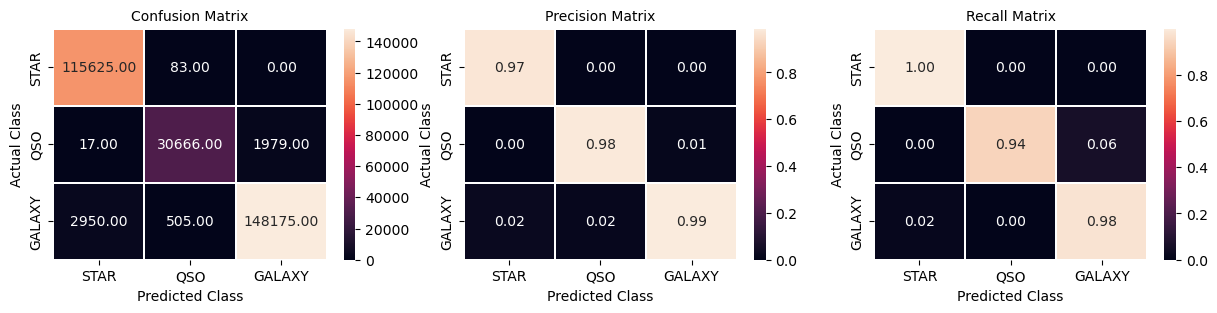

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98    151630
         QSO       0.98      0.94      0.96     32662
        STAR       0.97      1.00      0.99    115708

    accuracy                           0.98    300000
   macro avg       0.98      0.97      0.98    300000
weighted avg       0.98      0.98      0.98    300000

Test
Logloss: 0.076
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


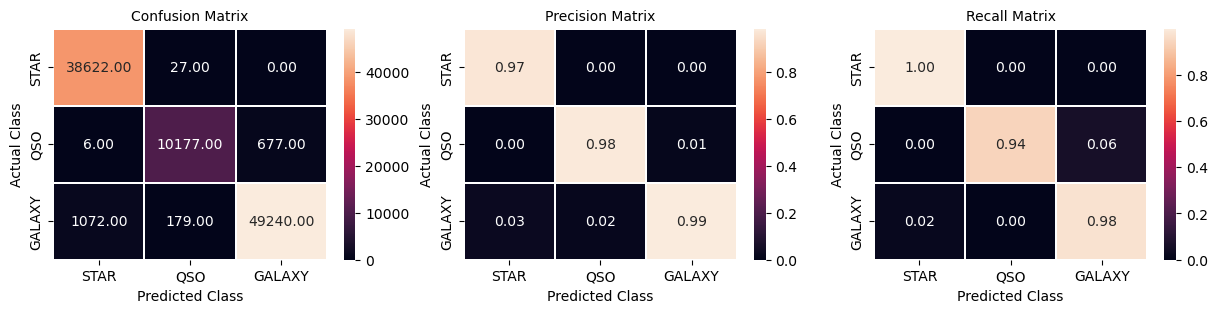

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98     50491
         QSO       0.98      0.94      0.96     10860
        STAR       0.97      1.00      0.99     38649

    accuracy                           0.98    100000
   macro avg       0.98      0.97      0.97    100000
weighted avg       0.98      0.98      0.98    100000

Validation
Logloss: 0.075
Column sum of precision matrix: [1. 1. 1.]
Row sum of recall matrix:       [1. 1. 1.]


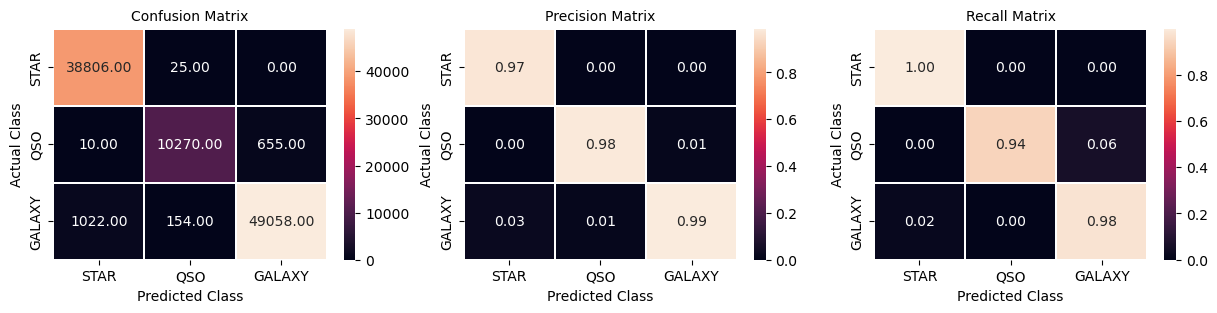

              precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98     50234
         QSO       0.98      0.94      0.96     10935
        STAR       0.97      1.00      0.99     38831

    accuracy                           0.98    100000
   macro avg       0.98      0.97      0.98    100000
weighted avg       0.98      0.98      0.98    100000



In [14]:
training_loss = reporter(clf=clf, X=X_train, y=y_train, title='Train', labels=labels)
test_loss = reporter(clf=clf, X=X_test, y=y_test, title='Test', labels=labels)
val_loss = reporter(clf=clf, X=X_val, y=y_val, title='Validation', labels=labels)

In [15]:
def genetic_opt(clf, params, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
    ga_clf = GASearchCV(estimator=clf,
                        cv=cv,
                        scoring='accuracy',
                        population_size=10,
                        generations=5,
                        tournament_size=3,
                        elitism=True,
                        crossover_probability=0.5,
                        mutation_probability=0.1,
                        param_grid=params,
                        criteria='max',
                        algorithm='eaMuPlusLambda',
                        n_jobs=-1,
                        verbose=True,
                        keep_top_k=3)
    search = ga_clf.fit(X=X,y=y)
    return search.best_params

In [16]:
labels

array(['STAR', 'QSO', 'GALAXY'], dtype=object)

In [22]:
clf = LogisticRegressionCV(solver='saga',max_iter=1000,n_jobs=-1,penalty='l2',random_state=random_seed)

param_grid = {
    'Cs':Integer(10,1000,random_state=random_seed)
    }
best = genetic_opt(clf=clf, params=param_grid, X=X_train, y=y_train)

KeyboardInterrupt: 

In [ ]:
best

In [ ]:
ga_clf = LogisticRegressionCV(Cs=best['Cs'],penalty=best['penalty'],solver=best['solver'], random_state=random_seed)

ga_clf.fit(X_train,y_train)

training_loss = reporter(clf=ga_clf, X=X_train, y=y_train, title='Train', labels=labels)
testing_loss = reporter(clf=ga_clf, X=X_test, y=y_test, title='Test', labels=labels)
val_loss = reporter(clf=ga_clf, X=X_val, y=y_val, title='Validation', labels=labels)